# Trump's tweets and the stock market

Prepared by [Vincent Grégoire](http://www.vincentgregoire.com), Department of Finance, The University of Melbourne. 

This is a sample code to illustrate how you can merge and analyze twitter data, textual (sentiment) analysis and intraday stock market data in Python.

This code loads all President Trump's tweets since the inauguration, analyzes the sentiment of the content and looks at the volume and volatility in the market following the tweet (hint: there is no noticeable impact).

This notebook was created as supplemental material to a Python for financial research bootcamp for finance honours and PhD students at the University of Melbourne in March of 2017.

Last update: March 29, 2017.

**Contact**: <vincent.gregoire@unimelb.edu.au>

Latest version: <http://www.vincentgregoire.com/python-bootcamp/>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
# For this one, cartoon-style plots seem appropriate.
plt.xkcd()
import json

I use to additional packages for this project.

### [python-twitter](https://github.com/bear/python-twitter)

One of the many package that lets you access the Twitter API using Python. You can install from the terminal:

`pip install python-twitter`

### [TextBlob](https://textblob.readthedocs.io/en/dev/)

This is a nice package with an easy interface for textual analysis. It uses the much more complex [NLTK](http://www.nltk.org/) under the hood.. You can install from the terminal:

`pip install textblob`

In [2]:
from textblob import TextBlob
import twitter

In order to use the Twitter API, you need to register yourself and your application (this code!) on [Twitter's developper platform](https://dev.twitter.com/). I have placed my keys in a JSON file called 'twitter_keys.json'.

In [3]:
with open('twitter_keys.json', 'r') as f:
    keys = json.JSONDecoder().decode(f.read())
    
api = twitter.Api(consumer_key=keys['consumer_key'],
                  consumer_secret=keys['consumer_secret'],
                  access_token_key=keys['access_token_key'],
                  access_token_secret=keys['access_token_secret'])

In [4]:
# Inauguration day
start_date = datetime(2017, 1, 20)

We begin by downloading the latest tweets (API limits to 200 at a time), and then loop back until we have the inauguration date.

In [5]:
statuses = []

# Download tweets until we reach before the inauguration date.
done = False
max_id=None
while not done:
    tmp = api.GetUserTimeline(screen_name='realdonaldtrump',
                              count=200, max_id=max_id)
    statuses = statuses + tmp
    a = tmp[-1]
    max_id = a.id-1
    done = pd.to_datetime(a.created_at) < start_date

stat_list = [[pd.to_datetime(x.created_at), x.text] for x in statuses]
tweets = pd.DataFrame(stat_list)
tweets.columns = ['timestamp', 'text']

tweets = tweets[tweets.timestamp >= start_date].copy()

print(str(len(tweets)) + ' tweets since inauguration.')

338 tweets since inauguration.


In [6]:
tweets.head()

,timestamp,text
0,2017-03-28 15:26:23,The failing @NYTimes would do much better if t...
1,2017-03-28 11:16:44,Watch @foxandfriends now on Podesta and Russia!
2,2017-03-28 10:36:02,Big announcement by Ford today. Major investme...
3,2017-03-28 02:03:17,The Democrats will make a deal with me on heal...
4,2017-03-28 01:41:15,The Republican House Freedom Caucus was able t...


Next we'll use TextBlob to compute each tweet's sentiment measure, which goes from -1 (negative) to +1 (positive). This is an easy way to get sentiment, but for serious research one would need to assess if the underlying algorithm is appropriate for the task. It this case it seems to do an ok job, but not perfect.

In [7]:
# Compute the tweets' sentiment
def getSentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

tweets['sentiment'] = tweets['text'].apply(getSentiment)

In [8]:
print('TOP 10 NEGATIVE TWEETS\n')
for row in tweets.sort_values('sentiment').head(10).iterrows():
    print (row[1]['text'] + '\n')

TOP 10 NEGATIVE TWEETS

RT @foxandfriends: "Never give up....that's the worst thing you could do. There's always a chance." -Kyle Coddington's message to those als…

Iran has been formally PUT ON NOTICE for firing a ballistic missile.Should have been thankful for the terrible deal the U.S. made with them!

If Chicago doesn't fix the horrible "carnage" going on, 228 shootings in 2017 with 42 killings (up 24% from 2016), I will send in the Feds!

122 vicious prisoners, released by the Obama Administration from Gitmo, have returned to the battlefield. Just another terrible decision!

Terrible! Just found out that Obama had my "wires tapped" in Trump Tower just before the victory. Nothing found. This is McCarthyism!

We must keep "evil" out of our country!

find the leakers within the FBI itself. Classified information is being given to media that could have a devastating effect on U.S. FIND NOW

Everybody is arguing whether or not it is a BAN. Call it what you want, it is about keeping ba

In [9]:
print('TOP 10 POSITIVE TWEETS\n')
for row in tweets.sort_values('sentiment', ascending=False).head(10).iterrows():
    print (row[1]['text'] + '\n')

TOP 10 POSITIVE TWEETS

Welcome to the United States, @IsraeliPM Benjamin &amp; Sara!
#ICYMI🇺🇸🇮🇱Joint Press Conference: 
https://t.co/GN6ALWUusN https://t.co/bH60nBL5FP

Happy #MedalOfHonorDay to our heroes! ➡️https://t.co/juAB1RmMh0 https://t.co/Sw5ea1OwUf

In Nashville, Tennessee! Lets MAKE AMERICA GREAT AGAIN! https://t.co/m5UR4vv6UH

Congratulations Eric &amp; Lara. Very proud and happy for the two of you! https://t.co/s0T3cTQc40

Met with @RepCummings today at the @WhiteHouse. Great discussion!

MAKE AMERICA GREAT AGAIN! https://t.co/kuQiZDz4rA

Great listening session with CEO's of the Retail Industry Leaders Association this morning! https://t.co/sy6xJcWfcF

Great meeting with the @RepublicanStudy Committee this morning at the @WhiteHouse! https://t.co/8Y2UoHoYaY

Wonderful meeting with Canadian PM @JustinTrudeau and a group of leading CEO's &amp; business women from Canada🇨🇦and th… https://t.co/wAoCOaYeZ6

Welcome to the @WhiteHouse Prime Minister @JustinTrudeau! https://t.co/W

Now these timestamps are in UTC time, we'll need to convert them to US eastern time to match stock market.

In [10]:
tweets = tweets.set_index('timestamp').tz_localize('UTC')
tweets = tweets.tz_convert('US/Eastern')

## "Seasonal" patterns in tweets.

Next, let's look at when these tweetoccurs. In the end, we'll want to focus on when markets are open.

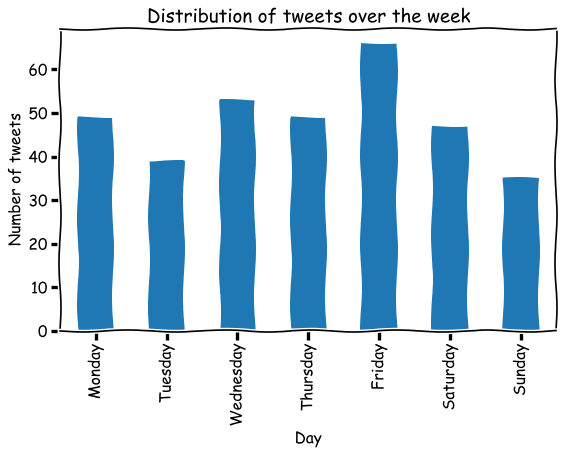

In [11]:
day_labels = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
              3: 'Thursday', 4: 'Friday', 5: 'Saturday',
              6: 'Sunday', }

count_days = tweets.groupby(tweets.index.dayofweek)['sentiment'].count()
count_days = count_days.reset_index()
count_days['Day'] = count_days['index'].map(day_labels)
count_days = count_days.set_index('Day')

fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=80)
count_days['sentiment'].plot(kind='bar', ax=axes)
axes.set_title('Distribution of tweets over the week')
axes.set_ylabel('Number of tweets')

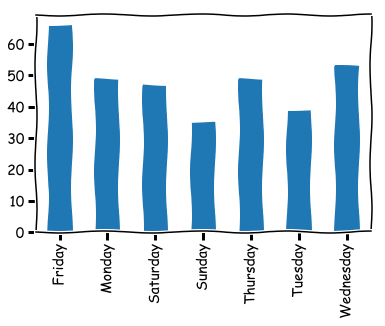

In [12]:
# For days of the week, pandas has an even easier function, 
# but the ordering (alphabetical) is not right for a plot
count_days2 = tweets.groupby(tweets.index.weekday_name)['sentiment'].count()
count_days2.plot(kind='bar')

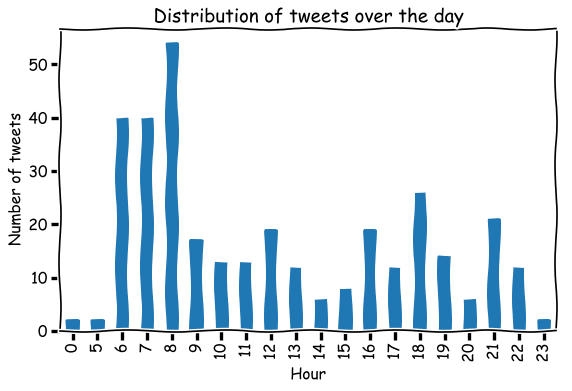

In [13]:
count_hours = tweets.groupby(tweets.index.hour)['sentiment'].count()
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=80)
count_hours.plot(kind='bar', ax=axes)
axes.set_title('Distribution of tweets over the day')
axes.set_ylabel('Number of tweets')
axes.set_xlabel('Hour')

# Tweets during market hours.

Ultimately, we want to look at tweets happening during regular trading hours.

With pandas we can easily filter out for business days (i.e. exlcude Sat and Sun) and filter for regular trading hours.

That's an easy fix, but what if there is a holiday? With pandas you
can create custom dates ranges that takes into account holidays. However,
in this case we have a very short time period (inauguration in Jan 2017,
this code written at end of March 2017), so it makes more sense to just
use a list of holidays that we get from the [NYSE website](https://www.nyse.com/markets/hours-calendars).
In turns out there is only one holiday (Washington's birthday, Feb 20)
and no early close days.

In [14]:
# Excluding Saturday and Sunday (days 5 and 6)
sel = ((tweets.index.dayofweek == 5) |
       (tweets.index.dayofweek == 6))
tweets = tweets[~sel].copy()

tweets = tweets[tweets.index.date != date(2017, 2, 20)].copy()

# Regular trading hours are 9:30 to 16:00. Suppose we want at least 30min
# of observations before and after, we only keep tweets that fall
# between 10am and 3:30pm.
sel = ((tweets.index.time >= time(10, 0, 0)) &
       (tweets.index.time <= time(15, 30, 0)))

tweets = tweets[sel].copy()

print('President Trump doesn\'t tweet that often when markets are open' +
      ', only ' + str(len(tweets)) + ' times since the inauguration (excluding first and last half-hour of trading).')

President Trump doesn't tweet that often when markets are open, only 56 times since the inauguration (excluding first and last half-hour of trading).


Now we're ready to load our market data. I retreived intraday 5-seconds snapshots of `SPY`, the SPDR S&P 500 ETF which is the most liquid equity instrument from [Thomson Reuters Tick History](https://tickhistory.thomsonreuters.com/), provided by [SIRCA](https://www.sirca.org.au/). 

In [15]:
# We only care about a subset of columns:
cols = ['Date[L]', 'Time[L]', 'Volume', 'Close Bid', 'Close Ask']

spy_df = pd.read_csv('SPY_2017_5sec.csv.gz', usecols=cols)

# We need to parse date and time. Before we do, we can do a bit of filtering
# based on time. Since you can compare strings based and alphanumeric 
# ordering, we can compare times even without filtering them...
sel = ((spy_df['Time[L]'] >= '09:30:00.000') & 
       (spy_df['Time[L]'] <= '16:00:00.000'))

spy_df = spy_df[sel].copy()

spy_df['Timestamp'] = spy_df['Date[L]'] + ' ' + spy_df['Time[L]']
spy_df['Timestamp'] = spy_df['Timestamp'].apply(
        lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S.000'))

spy_df = spy_df.set_index('Timestamp')

# We also throw out weekends and holidays (sometimes we get empty entries on those days.)
sel = ((spy_df.index.dayofweek == 5) |
       (spy_df.index.dayofweek == 6))
spy_df = spy_df[~sel]
spy_df = spy_df[spy_df.index.date != date(2017, 2, 20)].copy()

In [16]:
spy_df.head()

,Date[L],Time[L],Volume,Close Bid,Close Ask
Timestamp,,,,,
2017-01-03 09:30:00,01/03/2017,09:30:00.000,573501.0,225.08,225.09
2017-01-03 09:30:05,01/03/2017,09:30:05.000,81687.0,225.07,225.08
2017-01-03 09:30:10,01/03/2017,09:30:10.000,168742.0,225.04,225.05
2017-01-03 09:30:15,01/03/2017,09:30:15.000,67833.0,225.04,225.05
2017-01-03 09:30:20,01/03/2017,09:30:20.000,24882.0,225.04,225.05


First, we'll compute the mid quotes, and from that the log mid quote returns for each 5-seconds intervals.

Second, we'll resample at the 1 minute interval, computing the sum of squared 5-seconds return in each minute (our measure of volatility) and the total trading volume during that minute.

In [17]:
spy_df['MidQuote'] = (spy_df['Close Bid'] + spy_df['Close Ask'])/2.0
spy_df['LogMidQuote'] = np.log(spy_df['MidQuote'])

spy_df['LogRet'] = spy_df.groupby(spy_df.index.date)['LogMidQuote'].diff()

spy_df['SqLogRet'] = spy_df['LogRet']**2

spy1m_df = spy_df[['SqLogRet', 'Volume']].groupby(
        spy_df.index.date).resample('1T').sum().reset_index(level=0, drop=True)

In [18]:
spy1m_df.head()

,SqLogRet,Volume
Timestamp,,
2017-01-03 09:30:00,1.540792e-07,1252764.0
2017-01-03 09:31:00,1.581980e-07,631546.0
2017-01-03 09:32:00,9.491761e-08,330415.0
2017-01-03 09:33:00,6.522682e-08,262341.0
2017-01-03 09:34:00,1.342341e-07,363978.0


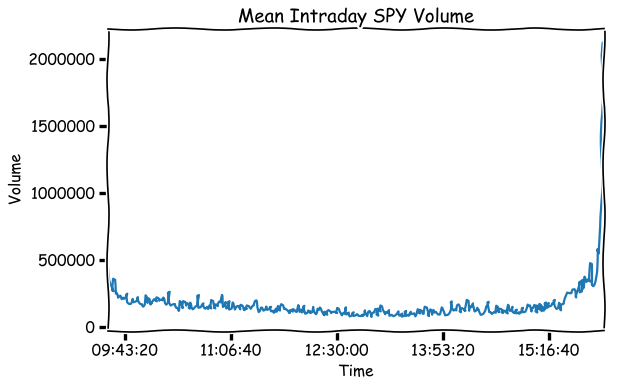

In [19]:
# Let's look at daily patterns

fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=80)
spy1m_df.groupby(spy1m_df.index.time)['Volume'].mean().plot(ax=axes)
axes.set_title('Mean Intraday SPY Volume')
axes.set_ylabel('Volume')
axes.set_xlabel('Time')

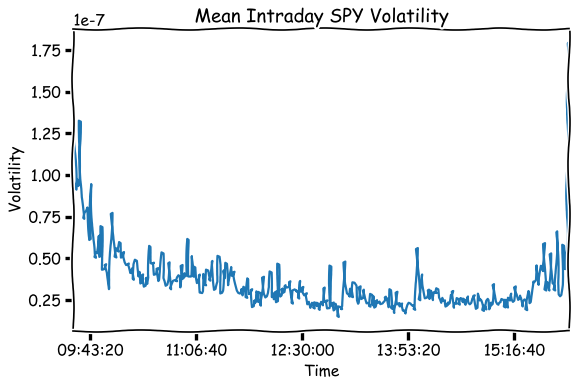

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=80)
spy1m_df.groupby(spy1m_df.index.time)['SqLogRet'].mean().plot(ax=axes)
axes.set_title('Mean Intraday SPY Volatility')
axes.set_ylabel('Volatility')
axes.set_xlabel('Time')

So there are strong intraday patterns in there. To account for that, we'll compute abnormal volume and volatility, defining abnormal as the difference with the previous 10 day average for the same time of day (minute).

In [21]:
roll_mean = spy1m_df.groupby(spy1m_df.index.time)[['Volume','SqLogRet']
    ].rolling(window=10, skipna=True).mean().reset_index().set_index('Timestamp')

In [22]:
spy1m_df['AbnVolume'] = spy1m_df['Volume'] - roll_mean['Volume']
spy1m_df['AbnSqLogRet'] = spy1m_df['SqLogRet'] - roll_mean['SqLogRet']

Let's check if that works well. Now we should see a noisy picture, but around a much smaller scale.

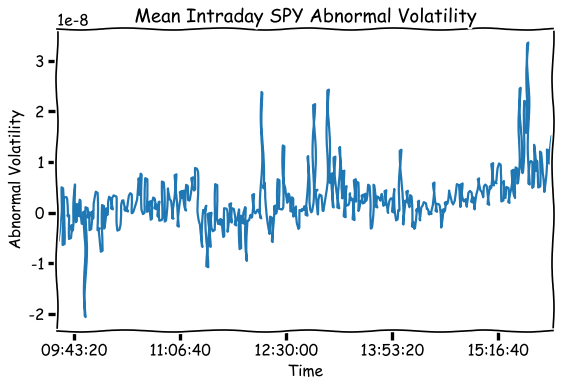

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=80)
spy1m_df.groupby(spy1m_df.index.time)['AbnSqLogRet'].mean().plot(ax=axes)
axes.set_title('Mean Intraday SPY Abnormal Volatility')
axes.set_ylabel('Abnormal Volatility')
axes.set_xlabel('Time')

## Looking at tweet "events"

In [24]:
# Now merge our events. To make things easier, we'll floor the timestamps of the tweets to the minute.
tweets['TS1M'] = tweets.index.floor('1T')

In [25]:
merged = pd.merge(tweets, spy1m_df.reset_index(),
                  left_on=tweets.reset_index()['timestamp'].dt.date,
                  right_on=spy1m_df.reset_index()['Timestamp'].dt.date)

To compute the "event time", we need to compute the difference between the observation time (TRTH) and the event (tweet). We can only compare two timestamps that are both naive (no timezone info) or tz aware. The tweet timestamp has been converted to aware already. The TRTH timestamp is labeled 'Time[L]' in the file, indicating it is in local  time (US/Eastern is this case), otherwise it would have been labeled 'Time[G]' (indicating UTC).

In [26]:
merged['event_t'] = merged['Timestamp'].dt.tz_localize('US/Eastern') - merged['TS1M']

In [27]:
# We want to keep +/- 30 minutes windows
sel = ((merged.event_t >= -timedelta(minutes=30)) &
       (merged.event_t <= timedelta(minutes=30)))

In [28]:
# Timedeltas don't plot well yet, so we convert to minutes to use as our axis.
merged = merged[sel].copy()
merged['t'] = merged['event_t'].dt.total_seconds()/60

In [29]:
def plot_event(df, varname, label='', title=''):
    events_mean = df.groupby('t')[varname].mean()
    se = (df.groupby('t')[varname].std()
          / np.sqrt(df.groupby('t')[varname].count()))

    fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=80)
    axes.set_title(title)
    events_mean.plot(ax=axes, color='b')
    (events_mean + 1.96*se).plot(ax=axes, color='b', linestyle=':', linewidth=1)
    (events_mean - 1.96*se).plot(ax=axes, color='b', linestyle=':', linewidth=1)
    axes.fill_between(events_mean.index, (events_mean - 1.96*se),
                      (events_mean + 1.96*se), facecolor='blue', alpha=0.1)
    axes.set_ylabel(label)
    axes.set_xlabel('Minutes')
    axes.axhline(y=0, linestyle='--', color='k')
    axes.axvline(x=0, linestyle='-', color='k')

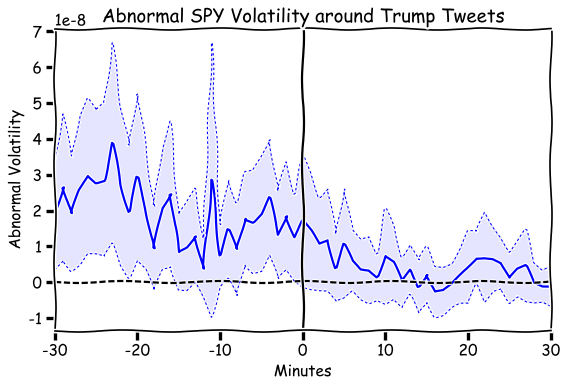

In [30]:
plot_event(merged, 'AbnSqLogRet', label='Abnormal Volatility',
           title='Abnormal SPY Volatility around Trump Tweets')

There is no abnormal market volatility following Trump's tweets. Interestingly, volatility appears to be higher prior to his tweets, perhaps he is responding to the market, or both are responding to the same event.

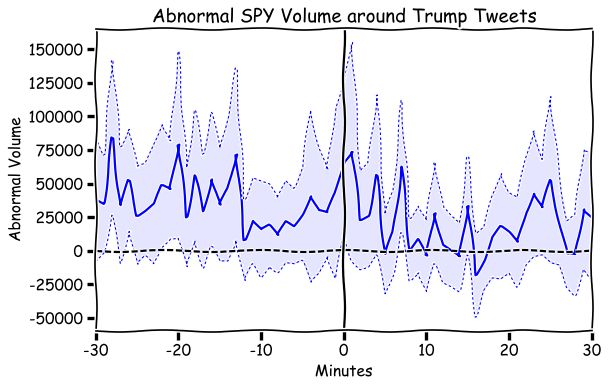

In [31]:
plot_event(merged, 'AbnVolume', label='Abnormal Volume',
           title='Abnormal SPY Volume around Trump Tweets')

## Markets and tweet sentiment

In [32]:
print('We have ' + str(sum(tweets.sentiment < 0)) + ' negative and ' +
      str(sum(tweets.sentiment > 0)) + ' postive tweets (the remainder are neutral).')

We have 4 negative and 28 postive tweets (the remainder are neutral).


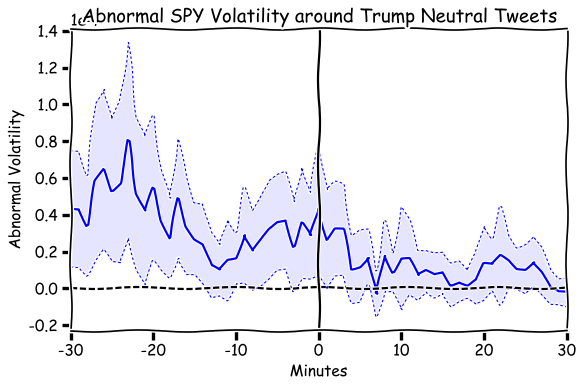

In [33]:
neutralsent = merged[merged.sentiment == 0 ]

plot_event(neutralsent, 'AbnSqLogRet', label='Abnormal Volatility',
           title='Abnormal SPY Volatility around Trump Neutral Tweets')

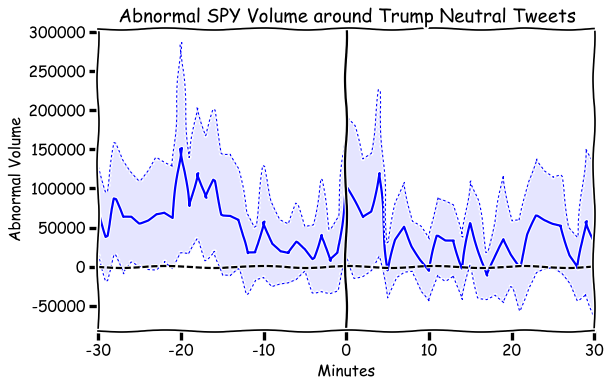

In [34]:
plot_event(neutralsent, 'AbnVolume', label='Abnormal Volume',
           title='Abnormal SPY Volume around Trump Neutral Tweets')

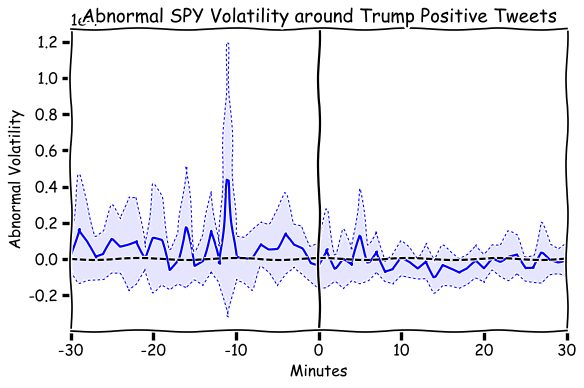

In [35]:
possent = merged[merged.sentiment > 0 ]

plot_event(possent, 'AbnSqLogRet', label='Abnormal Volatility',
           title='Abnormal SPY Volatility around Trump Positive Tweets')

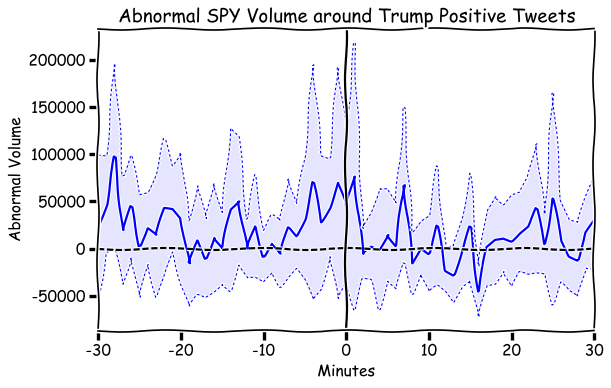

In [36]:
plot_event(possent, 'AbnVolume', label='Abnormal Volume',
           title='Abnormal SPY Volume around Trump Positive Tweets')